##### Imports

In [1]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from scipy.stats import pearsonr

from temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df, create_container_df

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sns.set(context = "notebook", style = "ticks", font="verdana", font_scale = 1.5)
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Paths/Fields

In [2]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/hl4_plot/")

path_shiny_human = os.path.join(csv_path, "current_shiny_human.csv")
path_ephys = os.path.join(csv_path, "ephys_hIVSCC_MET.csv")

In [3]:
ephys_list = ["Vm(mV)", "Input Resistance(MΩ)", "Sag Fraction", "τ(s)", "LS AP up/downstoke", "Latency", "F-I Curve"]
region_list = ["FCx", "OCx", "PCx", "TCx"]

fields_ephys = ["name", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]

fields_shiny = ["cell_name", "roi", "cell_specimen_project", "Norm_Marker_Sum.0.4_label",
                "marker_sum_norm_label", "rna_amplification_pass_fail",
                "percent_cdna_longer_than_400bp", "amplified_quantity_ng", "sample_id", 
                "Tree_call", "seurat_prediction_score_label", "seurat_cluster_label",
                "broad_class_label", "subclass_label"]

shiny_dict = {"Norm_Marker_Sum.0.4_label" : "NMS Pass/Fail",
              "rna_amplification_pass_fail" : "RNA Amp Pass/Fail",
              "marker_sum_norm_label": "NMS score",
              "percent_cdna_longer_than_400bp" : "cDNA quality (%>400 bp)",
              "amplified_quantity_ng" : "Amplified content (ng)",
              "seurat_prediction_score_label": "Seurat prediction score"}

##### Filtering shiny

In [4]:
shiny_human = read_file(path_shiny_human, fields_shiny) #3592 rows
shiny_human.rename(columns=shiny_dict, inplace=True)
shiny_human["NMS Pass/Fail"] = shiny_human["NMS Pass/Fail"].replace({True: "Pass", False: "Fail"})

shiny_human["region"] = pd.np.where(shiny_human.roi.str.contains("FCx"), "FCx", 
                                    pd.np.where(shiny_human.roi.str.contains("OCx"), "OCx", 
                                    pd.np.where(shiny_human.roi.str.contains("PCx"), "PCx",
                                    pd.np.where(shiny_human.roi.str.contains("TCx"), "TCx", "Unknown/Misc"))))

shiny_human["layer"] = pd.np.where(shiny_human.roi.str.contains("L1"), "L1", 
                                   pd.np.where(shiny_human.roi.str.contains("L2"), "L2",
                                   pd.np.where(shiny_human.roi.str.contains("L3"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L4"), "L4", 
                                   pd.np.where(shiny_human.roi.str.contains("L5"), "L5",
                                   pd.np.where(shiny_human.roi.str.contains("L6"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("L2-3"), "L2-3",
                                   pd.np.where(shiny_human.roi.str.contains("L3a"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3b"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L3c"), "L3",
                                   pd.np.where(shiny_human.roi.str.contains("L6a"), "L6",
                                   pd.np.where(shiny_human.roi.str.contains("LL1"), "LL1", 
                                   pd.np.where(shiny_human.roi.str.contains("LL2"), "LL2", 
                                   pd.np.where(shiny_human.roi.str.contains("LL3"), "LL3",
                                   pd.np.where(shiny_human.roi.str.contains("LL4"), "LL4", 
                                   pd.np.where(shiny_human.roi.str.contains("LL5"), "LL5", "unknown_layer"))))))))))))))))

INFO:temp_funcs:Read file in as a pandas dataframe


##### Filtering ephys

In [5]:
ephys = read_file(path_ephys, fields_ephys) #1449 rows
ephys.rename(columns={"vrest": "Vm(mV)", 
                      "ri": "Input Resistance(MΩ)",
                      "sag" : "Sag Fraction", 
                      "tau": "τ(s)",
                      "upstroke_downstroke_ratio_long_square": "LS AP up/downstoke", 
                      "latency" : "Latency",
                      "f_i_curve_slope" : "F-I Curve"}, inplace=True)

INFO:temp_funcs:Read file in as a pandas dataframe


##### h_l4

In [9]:
h_l4 = filter_df(shiny_human, "layer", "L4") #474 rows

INFO:temp_funcs:Filtered dataframe based on layer == L4


##### tcx

In [14]:
fcx = filter_df(h_l4, "region", "FCx") #90 rows
fcx = filter_df(fcx, "NMS Pass/Fail", "Pass") #54 rows

INFO:temp_funcs:Filtered dataframe based on region == FCx
INFO:temp_funcs:Filtered dataframe based on NMS Pass/Fail == Pass


In [15]:
fcx.count()

sample_id                  54
cell_name                  54
roi                        54
cDNA quality (%>400 bp)    54
RNA Amp Pass/Fail          54
Amplified content (ng)     54
cell_specimen_project      53
NMS score                  54
NMS Pass/Fail              54
seurat_cluster_label       54
Seurat prediction score    54
broad_class_label          54
subclass_label             54
Tree_call                  54
region                     54
layer                      54
dtype: int64

##### Merged fcx with ephys

In [21]:
merged = merge_dataframes(fcx, ephys, "cell_name", "name", "inner") #37 rows
merged.dropna(subset=ephys_list, inplace=True) #27 rows
merged.sort_values(by="seurat_cluster_label", inplace=True)

INFO:temp_funcs:Merged two pandas dataframe into one dataframe


In [22]:
merged.count()

sample_id                  27
cell_name                  27
roi                        27
cDNA quality (%>400 bp)    27
RNA Amp Pass/Fail          27
Amplified content (ng)     27
cell_specimen_project      27
NMS score                  27
NMS Pass/Fail              27
seurat_cluster_label       27
Seurat prediction score    27
broad_class_label          27
subclass_label             27
Tree_call                  27
region                     27
layer                      27
name                       27
Vm(mV)                     27
Input Resistance(MΩ)       27
Sag Fraction               27
τ(s)                       27
LS AP up/downstoke         27
Latency                    27
F-I Curve                  27
dtype: int64

##### Seurat list with greater than 5 datapoints

In [23]:
seurat_list =[]
for n in merged["seurat_cluster_label"].unique():
        value = merged[merged["seurat_cluster_label"] == n]["Vm(mV)"].count() >= 5
        if value == True:
            seurat_list.append(n)

In [24]:
seurat_sorted_list = sorted(seurat_list)
seurat_sorted_list

['Exc L3-5 RORB ESR1']

##### Plot Colors

In [30]:
exc_inh_colors=["#ef3b2c"]

##### Clustered Boxplot for FCx

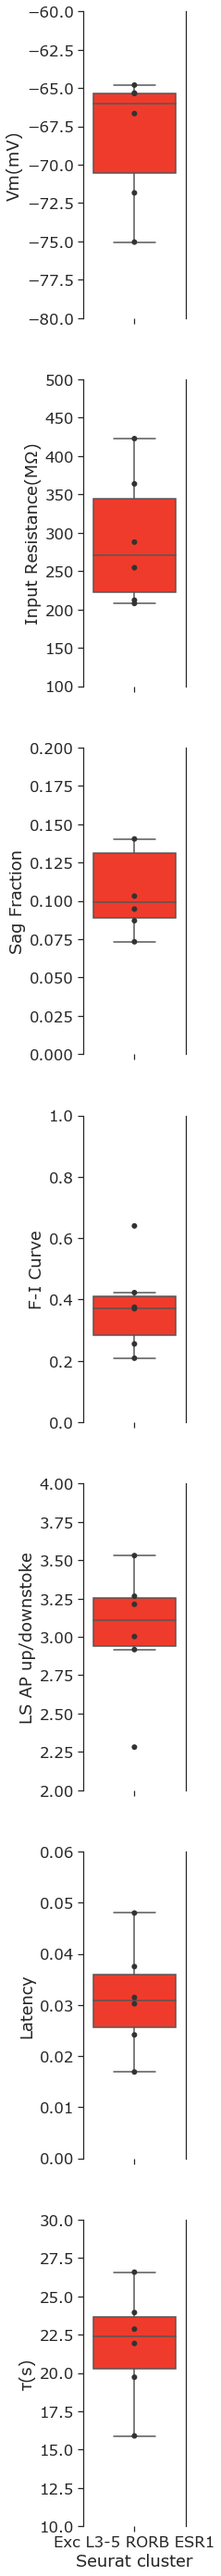

In [34]:
f, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 50))

ax = sns.boxplot(x="seurat_cluster_label", y="Vm(mV)", data=merged, order=seurat_sorted_list, showfliers=False,
            palette=exc_inh_colors, saturation=1, ax=axes[0])
ax = sns.stripplot(x="seurat_cluster_label", y="Vm(mV)", data=merged, order=seurat_sorted_list,
              color="0.2", size=6, jitter=False, ax=axes[0])

ax1 = sns.boxplot(x="seurat_cluster_label", y="Input Resistance(MΩ)", data=merged, order=seurat_sorted_list, showfliers=False,
            palette=exc_inh_colors, saturation=1, ax=axes[1])
ax1 = sns.stripplot(x="seurat_cluster_label", y="Input Resistance(MΩ)", data=merged, order=seurat_sorted_list,
              color="0.2", size=6, jitter=False, ax=axes[1])

ax2 = sns.boxplot(x="seurat_cluster_label", y="Sag Fraction", data=merged, order=seurat_sorted_list, showfliers=False,
            palette=exc_inh_colors, saturation=1, ax=axes[2])
ax2 = sns.stripplot(x="seurat_cluster_label", y="Sag Fraction", data=merged, order=seurat_sorted_list,
              color="0.2", size=6, jitter=False, ax=axes[2])

ax3 = sns.boxplot(x="seurat_cluster_label", y="F-I Curve", data=merged, order=seurat_sorted_list, showfliers=False,
            palette=exc_inh_colors, saturation=1, ax=axes[3])
ax3 = sns.stripplot(x="seurat_cluster_label", y="F-I Curve", data=merged, order=seurat_sorted_list,
              color="0.2", size=6, jitter=False, ax=axes[3])

ax4 = sns.boxplot(x="seurat_cluster_label", y="LS AP up/downstoke", data=merged, order=seurat_sorted_list, showfliers=False,
            palette=exc_inh_colors, saturation=1, ax=axes[4])
ax4 = sns.stripplot(x="seurat_cluster_label", y="LS AP up/downstoke", data=merged, order=seurat_sorted_list,
              color="0.2", size=6, jitter=False, ax=axes[4])

ax5 = sns.boxplot(x="seurat_cluster_label", y="Latency", data=merged, order=seurat_sorted_list, showfliers=False,
            palette=exc_inh_colors, saturation=1, ax=axes[5])
ax5 = sns.stripplot(x="seurat_cluster_label", y="Latency", data=merged, order=seurat_sorted_list,
              color="0.2", size=6, jitter=False, ax=axes[5])

ax6 = sns.boxplot(x="seurat_cluster_label", y="τ(s)", data=merged, order=seurat_sorted_list, showfliers=False,
            palette=exc_inh_colors, saturation=1, ax=axes[6])
ax6 = sns.stripplot(x="seurat_cluster_label", y="τ(s)", data=merged, order=seurat_sorted_list,
              color="0.2", size=6, jitter=False, ax=axes[6])

ax.set(xticklabels=[])
ax1.set(xticklabels=[])
ax2.set(xticklabels=[])
ax3.set(xticklabels=[])
ax4.set(xticklabels=[])
ax5.set(xticklabels=[])

ax.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax4.set_xlabel("")
ax5.set_xlabel("")
ax6.set_xlabel("Seurat cluster")
sns.despine(bottom=True, right=False)

ax.set(ylim=(-80, -60))
ax1.set(ylim=(100, 500))
ax2.set(ylim=(0, 0.2))
ax3.set(ylim=(0, 1))
ax4.set(ylim=(2, 4))
ax5.set(ylim=(0, 0.06))
ax6.set(ylim=(10, 30))

plt.xticks(rotation=0)
plt.savefig(plot_path + "fcx_seurat_bxplot.jpeg", bbox_inches="tight")